In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from state_space import simulator,system
from state_space.base import InputWarpper,Timer
from state_space.system import Pendulm
from state_space.simulator import DynamicSystem,Variable,WhiteNoise,TimerVariable

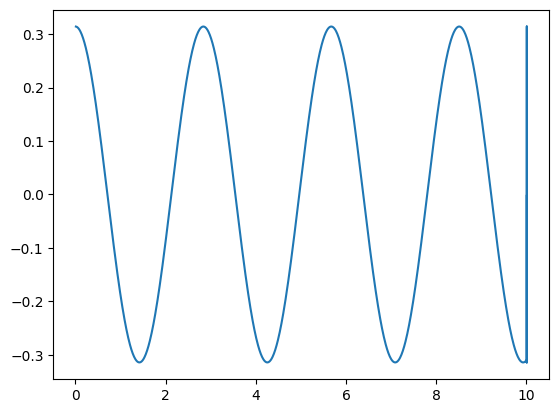

In [2]:
pendulm = Pendulm(1,2)
simulator = DynamicSystem(pendulm.A,pendulm.B,pendulm.C,pendulm.D,Timer(10))
simulator.init(np.array([[np.pi/10],[0]]))
theta = []
for step in range(10000):
    t = simulator.update(0)
    simulator.timer.update()
    theta.append([simulator.t,t.item()])
    
theta = np.array(theta)
plt.plot(theta[:,0],theta[:,1])
# simulator.u= 0
# simulator.simulate()

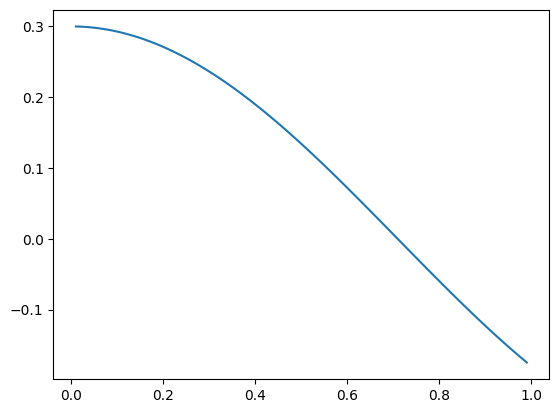

In [3]:
simulator.init(np.array([[0.3],[0]]))
simulator.set_u(0)
simulator.set_t_stop(1)
history = []
for i in simulator:
    history.append([simulator.t,i.item()])
history = np.array(history)
plt.plot(history[:,0],history[:,1])

[[-0.36319347]]


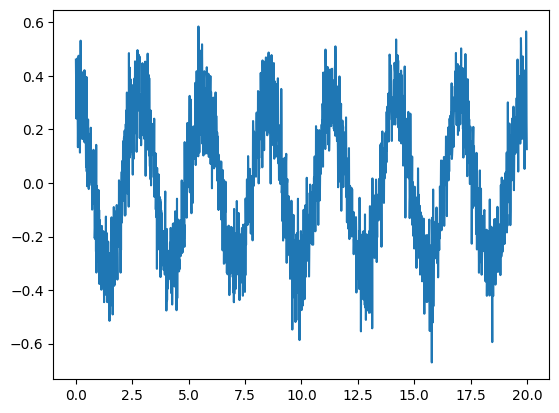

In [4]:
simulator = DynamicSystem(pendulm.A,pendulm.B,pendulm.C,pendulm.D)
simulator.init(np.array([[np.pi/10],[0]]))
simulator.set_u(0)
simulator.set_t_stop(20)
noise = WhiteNoise(0,0.3)
measure_noise = WhiteNoise(0,0.1)
simulator.u = noise
history = []
for i in simulator:
    history.append([simulator.t,i.item()+measure_noise.y.item()])
history = np.array(history)
plt.plot(history[:,0],history[:,1])
print(simulator.u)

In [5]:

from state_space.kalman_filter import KalmanFilter
from state_space.simulator import DiscreteDynamicSystem
simulator = DynamicSystem(pendulm.A,pendulm.B,pendulm.C,pendulm.D)
dis_simulator = DiscreteDynamicSystem.from_continous(simulator,np.array([[np.pi/10],[0]]))
filter = KalmanFilter(dis_simulator._A,dis_simulator._B,dis_simulator._C,dis_simulator._x,np.diag((0,1)))

[[0.03465768]]


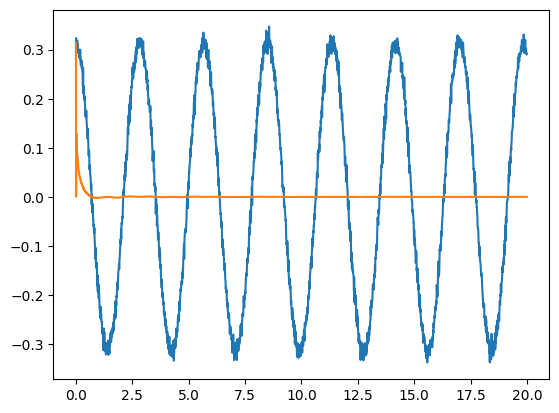

In [6]:
simulator.init(np.array([[np.pi/10],[0]]))
filter.init(simulator.x)
simulator.set_t_stop(20)
noise = WhiteNoise(0,0.03)
measure_noise = WhiteNoise(0,0.01)
simulator.u = noise
history = []
for i in simulator:
    y = i.item()+measure_noise.y.item()
    _,pre = filter.predict(simulator.u)
    filter.update(y)
    history.append([simulator.t,y,pre.item()])
    # history.append([simulator.t,y])
history = np.array(history)
plt.plot(history[:,0],history[:,1])
plt.plot(history[:,0],history[:,2])
print(simulator.u)

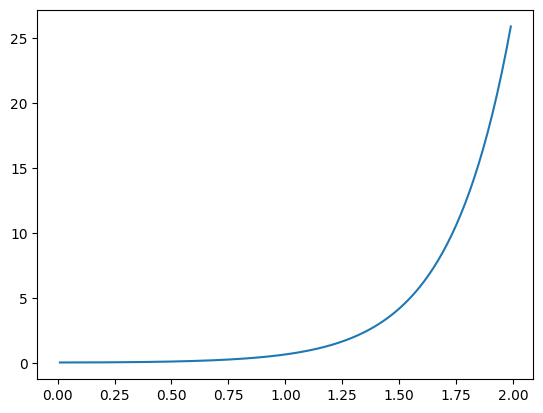

In [7]:
from state_space.system import InvertPendulm
m,M,L = 48,47.7,0.85
simulator = DynamicSystem.from_system(InvertPendulm(m,M,L))
simulator.init(np.array([[0],[0],[np.pi/100],[0]]))
simulator.set_u(0)
simulator.set_t_stop(2)
history = []
for i in simulator:
    history.append([simulator.t,i.item()])
history = np.array(history)
plt.plot(history[:,0],history[:,1])

In [8]:
from state_space.base import Timer
from state_space.transfer_function import Transfer
timer = Timer(10,0.001)
def cos(t):
    return np.cos(2*np.pi*t)
# s = Variable(0,0.001,10,cos)
s = TimerVariable(timer,cos)
a = Transfer([1],[1,2,14],0,timer)
a.u = s

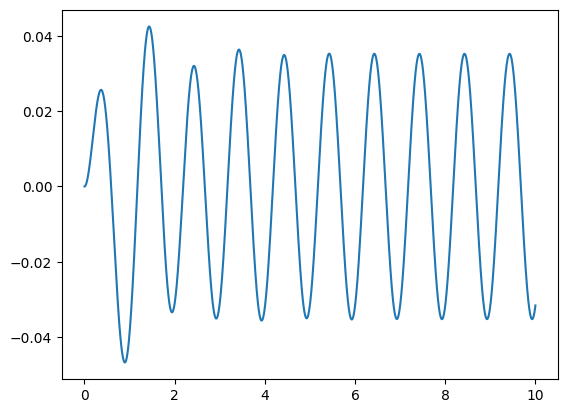

In [9]:
_ = a.simulate()

In [10]:
from state_space.transfer_function import Serial,FeedBack
f1 = Transfer([1],[1,2,14],0)
f2 = Transfer([1],[4,1],0)
f = Serial(f1,f2)
f1.u = 1
f2.u = 1
f.u = 1

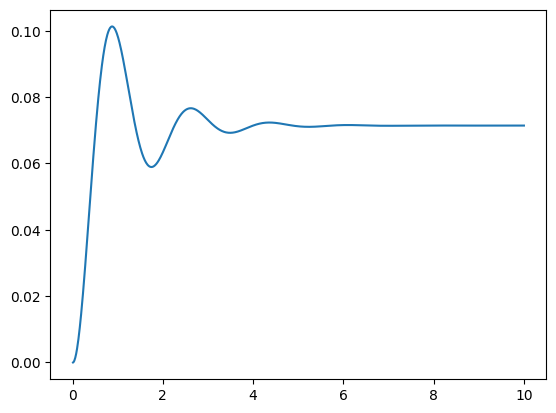

In [11]:
f1.u = 1
_ = f1.simulate()

In [12]:
def sigma(y):
    t = 0.02
    if y<t and y> -t:
        return 1/t
    else:
        return 0

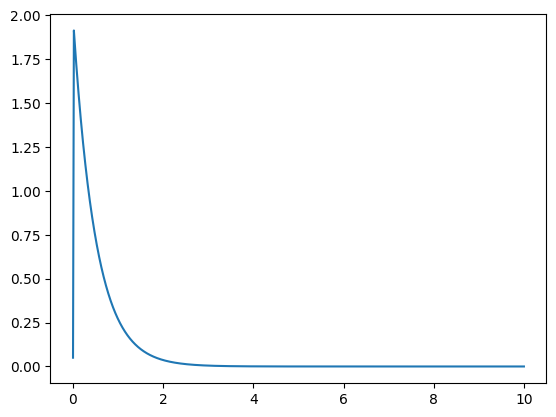

(0.4970000000000004, 1.9134209403483358)

In [13]:
T = 0.5
timer=Timer(10,0.0005)
u = TimerVariable(timer,sigma)
f2 = Transfer((1,),(T,1),timer=timer)
f2.init(0)
f2.u = u
y = f2.simulate()
#estimate T base on output
y[np.where(y[:,1]>(1/(T*np.e)))[0][-1],0],np.max(y[:,1])

0.4995000000000004

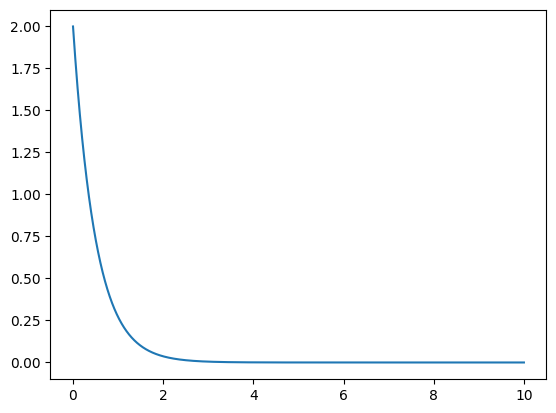

In [14]:
x = 1/T*np.exp(-y[:,0]/T)
plt.plot(y[:,0],x)
y[np.where(x>(1/(T*np.e)))[0][-1],0]

## Concat in System Map

In [15]:
from state_space.system_graph import Concat,BaseBlock
timer = Timer()
t1 = Transfer((1,),(2,1),timer=timer)
t2 = Transfer((1,),(1,2,1),timer=timer)
t1.u,t2.u = 1,1
con = Concat([t1,t2],(1,-1))

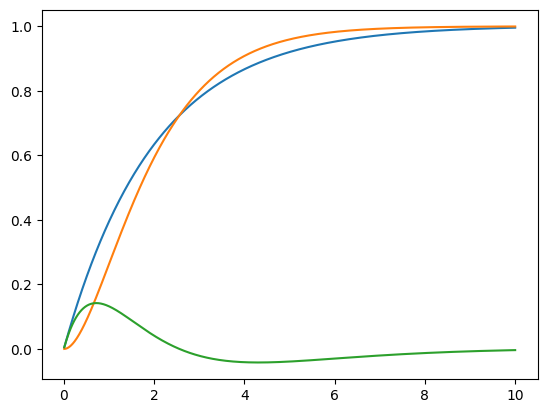

In [16]:
h = []
t1.init(np.array([[0]]))
t2.init(np.array([[0],[0]]))
for t in timer:
    y1 = t1.update_self()
    y2 = t2.update_self()
    h.append([t,y1.item(),y2.item(),con.y.item()])
h = np.array(h)
plt.plot(h[:,0],h[:,1])
plt.plot(h[:,0],h[:,2])
plt.plot(h[:,0],h[:,3])

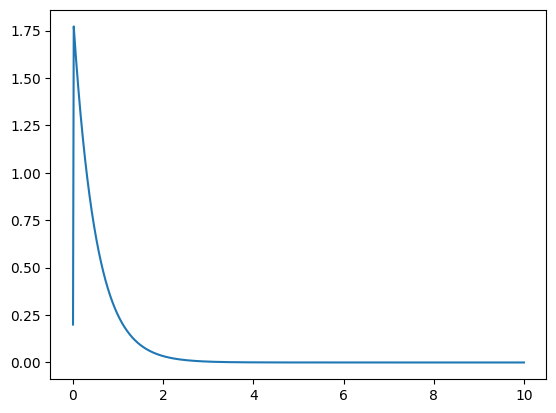

(0.45600000000000035, 1.7715237291154013)

In [17]:
# u = InputWarpper(1)
T = 0.5
timer = Timer(10,0.002)
t1 = Transfer((1,),(T,1),timer=timer)
u = TimerVariable(timer,sigma)
t1.u = u
y = t1.simulate()
T2 = y[np.where(y[:,1]>(1/(T*np.e)))[0][-1],0],np.max(y[:,1])
T2

### Estimate of T

In [18]:
con1 = Concat([u,t1],(1,-1))
t1.u = con1
t1.init(0)
y1 =t1.simulate(False)
t1.u = u
t1.init(0)
y2 = t1.simulate(False)
T1 = y1[np.where(y1[:,1]>(1/(T*np.e)))[0][-1],0],np.max(y1[:,1])
T2 = y2[np.where(y2[:,1]>(1/(T*np.e)))[0][-1],0],np.max(y2[:,1])
T1,T2

((0.23200000000000018, 1.7435178892047647),
 (0.45600000000000035, 1.7715237291154013))

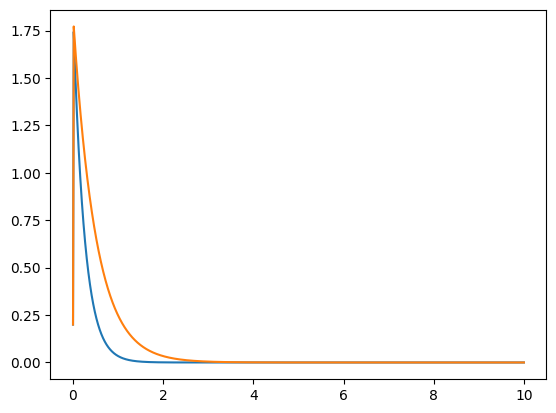

In [19]:
plt.plot(y1[:,0],y1[:,1])
plt.plot(y2[:,0],y2[:,1])

### Step function

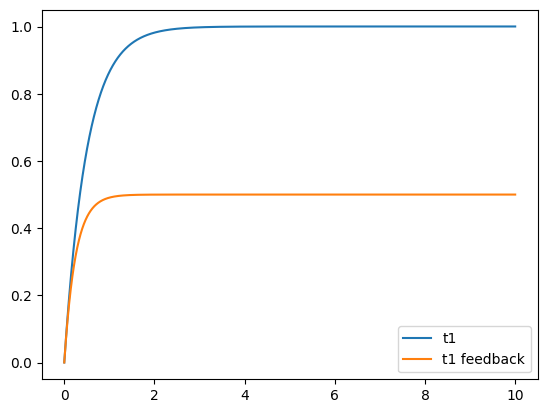

In [20]:
u = InputWarpper(1)
T = 0.5
timer = Timer(10,0.0002)
t1 = Transfer((1,),(T,1),timer=timer)
t1.u = u
con2 = Concat([u,t1],(1,-1))
y1 = t1.simulate(False)
t1.init(np.array([[0]]))
t1.u = con2
y2 = t1.simulate(False)
plt.plot(y1[:,0],y1[:,1])
plt.plot(y2[:,0],y2[:,1])
plt.legend(["t1","t1 feedback"])

### Ramp

3.960253951560322

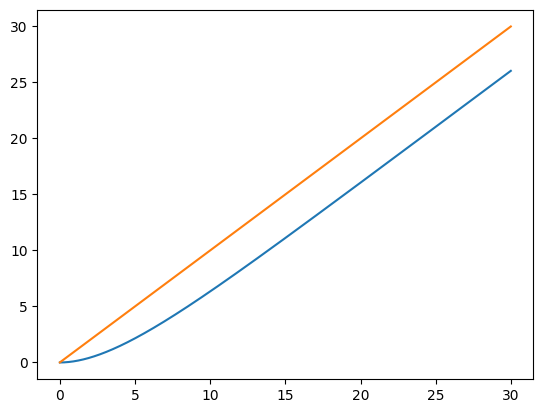

In [21]:
T = 4
timer = Timer(30)
t3 = Transfer((1,),(T,1),timer=timer)
u = TimerVariable(timer)
t3.u = u
y = t3.simulate(False)
y1 = u.y - np.exp(-y[:,0]/T)
plt.plot(y[:,0],y[:,1])
plt.plot(y[:,0],y[:,0])
# plt.plot(y[:,0],y1)
y[-1,0]-y[-1,1]

### PID Controller

In [22]:
from state_space.transfer_function import Gain
from state_space.pid_controller import PIDController
timer = Timer(30)
pid = PIDController(1,0,0)

#### System Graph

3.960253951560322

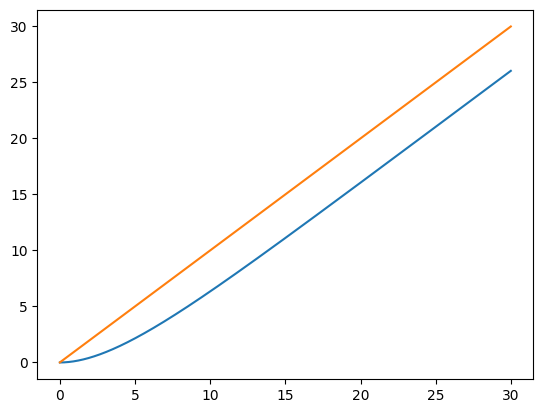

In [23]:
T = 4
t3 = Transfer((1,),(T,1),timer=timer)
u = TimerVariable(timer)
feedback = Gain(2,t3)
# feedback.u = t3
con2 = Concat([u,feedback],(1,-1))
t3.u = u
y = t3.simulate(False)
y1 = u.y - np.exp(-y[:,0]/T)
plt.plot(y[:,0],y[:,1])
plt.plot(y[:,0],y[:,0])
# plt.plot(y[:,0],y1)
y[-1,0]-y[-1,1]

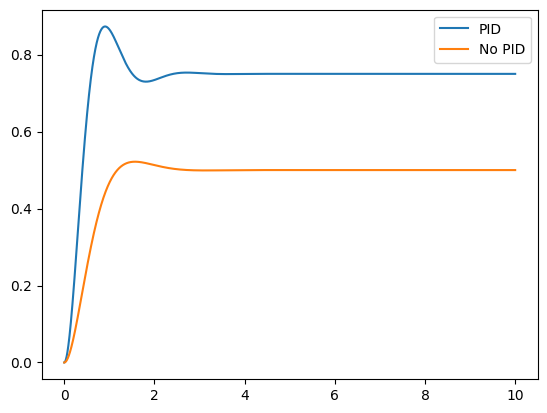

In [38]:
from state_space.system_graph import SystemGraph
timer = Timer(step=0.001)
# T = 1
# G = Transfer((1,),(T,1),timer=timer)
k,b = 2,1
G = Transfer((k**2,),(1,2*b*k,k**2),timer=timer)
u = TimerVariable(timer,lambda x:1)
H = Gain(1)
pid = PIDController(3,0,timer=timer)
# pid = Gain(1)
G.init(0)
graph = SystemGraph(
    systems=[u,pid,G,H],
    output=2,
    connections=((1,2),
                 (2,3),
                 ((0,3),1,(1,-1))),
    timer=timer)
y1 = graph.simulate(False)
# No pid
pid.init()
pid.kp = 1
graph.reset()
y2 = graph.simulate(False)
plt.plot(y1[:,0],y1[:,1])
plt.plot(y2[:,0],y2[:,1])
plt.legend(["PID","No PID"])

In [25]:
graph.concats

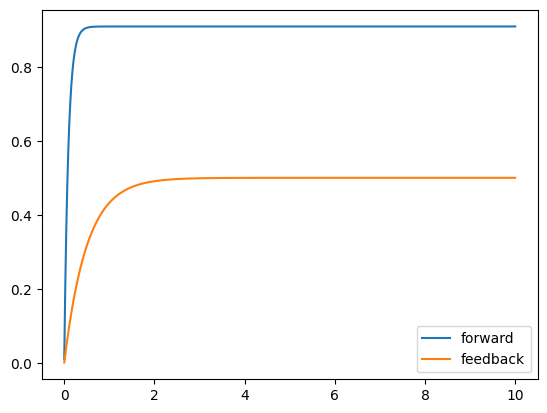

In [26]:
G.u = Concat([u,H],(1,-1))
H.u = G
G.init(0)
timer.init()
y2 = G.simulate(False)
plt.plot(y1[:,0],y1[:,1])
plt.plot(y2[:,0],y2[:,1])
plt.legend(["forward","feedback"])